In [1]:
import copy
import spacy
from spacy.lang.en import English
import pandas as pd
import numpy as np
from nltk import stem
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata
import re
from nltk.tokenize import word_tokenize
from collections import Counter 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import nltk
from sklearn import preprocessing #for label coding 0-ham; 1-spam
from sklearn.model_selection import KFold #for cv
from sklearn.feature_extraction.text import TfidfVectorizer #for TF-IDF vectorization

### Pre-Processing

In the pre-procssing step, we would like to filter out the not so useful data by achieving the following to prepare our texts:
<br>
- convert the texts into lower cases
- remove accented characters
- remove special characters (for example #, @ and more)
- remove stopwords
- remove punctuations
- lemmatize each word

#### remove accented characters

In order to remove accented characters, the texts are normalized using the compatibility decomposition known as the Normalization Form KD (NFKD). Since strings are stored as Unicode, each string in our texts is a sequence of code points as each character is represented by a code point. By encoding, the sequences of code points are converted into a set of bytes. In our case, we will encode the strings by both American Standard Code for Information Interchange (ascii) and UTF-8. 

#### remove special characters, stopwords and puncutations

To remove speical characters, we will strip the string and replace every character that is not a-z or A-Z.
<br>
<br>
The stopwords are the commonly used words (such as "the", "in", "an") that take up space in our database and take up processing time. We will removed the stopwords that are stored at "spacy.lang.en.English" from the texts.
<br>
<br>
In order to remove the punctuations, we will remove the characters from the texts that are not Unicode whitespace or Unicode word characters. 

#### lemmatization

When a word is lemmatized, it is returned to its root form. For example:
<br>
- words (lemmatizes to) word
- coding (lemmatizes to) code
- happily (lemmatizes to) happy

In [3]:
np.random.seed(123)

#get stopwords
stopwords = spacy.lang.en.stop_words.STOP_WORDS
#nlp = English()
#nlp = spacy.load("en") 
nlp = spacy.load('en_core_web_sm')

In [4]:
nlp

In [5]:
message = pd.read_csv('/Users/yunatan38/Documents/Projects/Natural Language Processing/SPAM text message 20170820 - Data.csv')

In [6]:
message.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# This class returns the pre-processed the data
class MessageProcessing:
    
    def __init__(self, df, col, remove_digits):
        self.df = df
        self.col = col
        
        self.count()
        self.normalization(remove_digits=remove_digits)
        self.lem()
    
    def count(self):
        df = copy.deepcopy(self.df)
        col = copy.deepcopy(self.col)
        #convert message into lower cases
        df[self.col]=df[col].apply(lambda row: " ".join(row.lower() for row in row.split()))
        #find word count
        df["word_count"]=df[col].apply(lambda row: len(str(row).split(" ")))
        #find numerics count
        df["numerics_count"]=df[col].apply(lambda row: len([row for row in row.split() if row.isdigit()]))
        #find stopwords count
        df["stopword_count"]=df[col].apply(lambda row: len([row for row in row.split() if row in stopwords]))
        
        self.df = copy.deepcopy(df)
        
    def normalization(self, remove_digits=True):
        #
        df = copy.deepcopy(self.df)
        col = copy.deepcopy(self.col)
        #remove accented characters
        df[col]=df[col].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        
        # remove special characters such as # and @ and digits
        if remove_digits is True:
            pattern = r'[^a-zA-z\s]'
        else:
            pattern = r'[^a-zA-z0-9\s]'
        
        df[col] = df[col].str.replace(pattern, " ").str.strip()
        
        # removing stopwords
        df[col] = df[col].apply(lambda row: " ".join(row for row in row.split() if row not in stopwords))
        
        # remove punctuation
        df[col] = df[col].str.replace('[^\w\s]','')
        self.df = copy.deepcopy(df)
    
    
    def lem(self):
        df = copy.deepcopy(self.df)
        col = copy.deepcopy(self.col)
        
        #lemmatization
        df[col]=df[col].apply(lambda row: " ".join([x.lemma_ for x in nlp(row)]))
        #tokenization
        #df[col]= df[col].apply(lambda row: nlp(row))
        
        # using a stemmer
        #df[col] = " ".join([stemmer.stem(word) for word in df[col]])
        #lemmatization
        #df[col] = " ".join([lem.lemmatize(word) for word in df[col]])
        #df[col] = df[col].apply(lambda row: " ".join([df[col].lemma_ for w in nlp(row)]))
        self.df = copy.deepcopy(df)
        

In [8]:
msg = MessageProcessing(message, "Message", True).df

In [9]:
# First, we explore the ham texts
ham = msg.loc[message.Category == 'ham']
# combine the column of text messages into one raw text.
ham_msg=' '.join(ham.Message)

Let's use WordCloud to visualize the words used in both Ham and Spam. WordCloud illustrates the frequency and importance of each word using size - the bigger the word, the more frequently it was used in messages. 

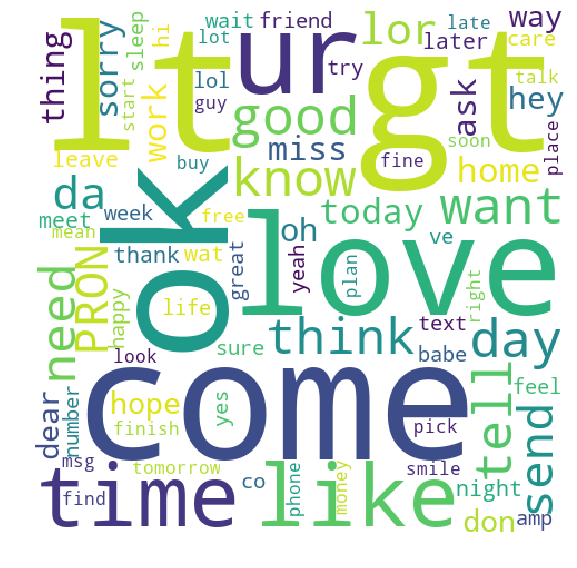

In [11]:
wordcloud_ham = WordCloud(width = 480, height = 480, 
                          background_color ='white', 
                          min_font_size = 15,
                          stopwords=stopwords,
                          random_state=3,
                          collocations=True).generate(ham_msg) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_ham) 
plt.axis("off") 
plt.tight_layout()
  
plt.show() 

In [12]:
spam = msg.loc[msg.Category=="spam"]
spam_msg = ','.join(spam.Message)

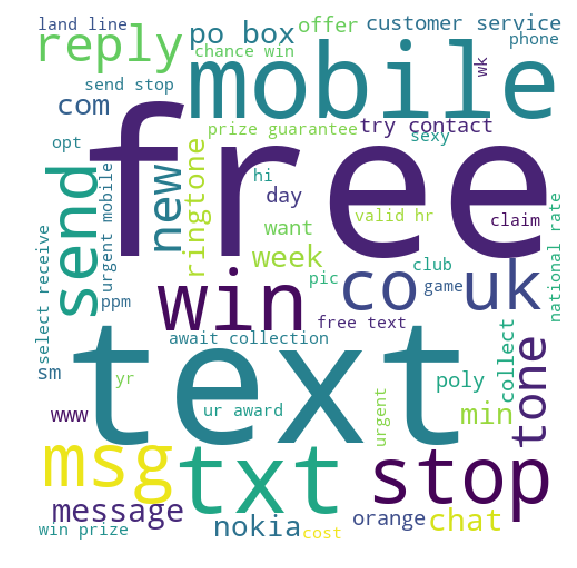

In [13]:
wordcloud_spam = WordCloud(width = 480, height = 480, 
                           background_color ='white',
                           stopwords=stopwords,
                           collocations=True,
                           random_state=1,
                           min_font_size = 15).generate(spam_msg) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8),facecolor = None) 
plt.imshow(wordcloud_spam) 
plt.axis("off") 
plt.tight_layout()

plt.show() 

In spam messages, the high frequency words are "free", "text", "call" and etc. However, in non-spam messages, there are a lot of personal words, such as "I'm", "ur", "like", "love" and etc. 

### Classification

In [14]:
# relabel the target variable to 0's and 1's
labelCode = preprocessing.LabelEncoder()
msg['Category'] = labelCode.fit_transform(msg['Category'])

In [15]:
# split data into training and testing sets

txt=msg[['Category', "Message"]]

x = txt.drop(['Category'], axis=1)
y = txt[['Category']]

kf = KFold(n_splits=10) #split into 10-fold
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

##### Vectorization

We will use the term frequency–inverse document frequency (TF-IDF) to vectorize the texts. 
<br>
- Term frequency (TF): How often a word appears in the texts. 
- Inverse document frequency (IDF): When a rarer word (such as Supercalifragilisticexpialidocious) shows up less frequently but is a good indication of the nature of the texts, IDF gives such words more weight in the vector representation.

TF-IDF is the product of TF and IDF for each token. We will use the TfidfVectorizer to achieve that by tokenizing the texts, learn the word and inverse frequency weightings, and encode new documents.

In [17]:
# use term frequency–inverse document frequency to vectorize the texts
v = TfidfVectorizer()
x_train_vect = v.fit_transform(x_train["Message"])
x_test_vect = v.fit_transform(x_test["Message"])

In [18]:
print(x_test_vect.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


To Be Continued